### 1. Import libraries

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%reload_ext autoreload

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from datetime import datetime

import os
import sys
import warnings

warnings.filterwarnings("ignore")

In [36]:
sys.path.append(os.path.abspath('../src/'))

#### Step 1: Load and Preprocess Data

In [37]:
from preprocess import data_loader


In [38]:
# Step 1: Load and Process Data
tickers = 'TSLA'
start_date = '2015-07-01'
#end_date = datetime.now().strftime('%Y-%m-%d')  # Up to current date
data = data_loader('../data/processed/clean_close_prices_for_analysis.csv')


In [39]:
# Convert Date to datetime, drop invalid rows
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
print("Invalid Date entries:\n", data[data['Date'].isna()][['Date', 'TSLA_Close']])
data = data.dropna(subset=['Date'])

Invalid Date entries:
 Empty DataFrame
Columns: [Date, TSLA_Close]
Index: []


In [40]:
tsla_close = data.set_index('Date')['TSLA_Close']

In [41]:
tsla_close

Date
2015-07-01     17.943333
2015-07-02     18.667999
2015-07-03     18.663000
2015-07-06     18.648001
2015-07-07     17.858667
                 ...    
2025-07-24    305.299988
2025-07-25    316.059998
2025-07-28    325.589996
2025-07-29    321.200012
2025-07-30    319.040009
Name: TSLA_Close, Length: 2631, dtype: float64

In [42]:
# Verify index type
print("Index type:", type(tsla_close.index))  # Should be DatetimeIndex
if not isinstance(tsla_close.index, pd.DatetimeIndex):
    raise ValueError("Index is not a DatetimeIndex. Check CSV loading and index setting.")

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


### 2. Split Data: Train (2015-2023), Test (2024-2025)

In [43]:
# 2. Split Data: Train (2015-2023), Test (2024-2025)
train_end = '2023-12-31'
test_start = '2024-01-01'
train = tsla_close[:train_end]
test = tsla_close[test_start:'2025-07-31']
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (2218,), Test shape: (413,)


In [44]:
tsla_close

Date
2015-07-01     17.943333
2015-07-02     18.667999
2015-07-03     18.663000
2015-07-06     18.648001
2015-07-07     17.858667
                 ...    
2025-07-24    305.299988
2025-07-25    316.059998
2025-07-28    325.589996
2025-07-29    321.200012
2025-07-30    319.040009
Name: TSLA_Close, Length: 2631, dtype: float64

## Prepare Models

In [45]:
# Step 2: SARIMA Model
model_auto = auto_arima(train, seasonal=True, m=5,
                        start_p=0, start_q=0, max_p=3, max_q=3,
                        start_P=0, start_Q=0, max_P=2, max_Q=2,
                        d=1, D=1, trace=True, error_action='ignore', 
                        suppress_warnings=True, maxiter=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=15599.522, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=14975.053, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=1.24 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=15593.827, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=14701.695, Time=0.76 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=2.31 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=14701.654, Time=0.47 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=14980.012, Time=0.28 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=14701.730, Time=0.60 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=14698.482, Time=1.67 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=14968.679, Time=0.93 sec
 ARIMA(1,1,1)(2,1,1)[5]             : AIC=inf, Ti

In [15]:
# Fit SARIMA
p, d, q = model_auto.order
P, D, Q, s = model_auto.seasonal_order
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit(disp=False)

In [16]:
# Forecast
sarima_forecast = sarima_fit.get_forecast(steps=len(test))
sarima_pred = sarima_forecast.predicted_mean
sarima_conf = sarima_forecast.conf_int()

In [17]:
sarima_pred

2024-01-01    247.195518
2024-01-02    248.586600
2024-01-03    247.555053
2024-01-04    251.276460
2024-01-05    249.761452
                 ...    
2025-07-24    184.250552
2025-07-25    181.620064
2025-07-28    181.780586
2025-07-29    183.660278
2025-07-30    183.037573
Freq: B, Name: predicted_mean, Length: 413, dtype: float64

In [18]:
sarima_conf

,lower TSLA_Close,upper TSLA_Close
2024-01-01,234.083295,260.307740
2024-01-02,230.408478,266.764723
2024-01-03,225.226319,269.883786
2024-01-04,225.590998,276.961922
2024-01-05,221.022748,278.500155
...,...,...
2025-07-24,-6062.130556,6430.631659
2025-07-25,-6087.143019,6450.383148
2025-07-28,-6109.834527,6473.395698
2025-07-29,-6130.705632,6498.026189


In [19]:
print("SARIMA Model Summary:\n", sarima_fit.summary())

SARIMA Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                         TSLA_Close   No. Observations:                 2218
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 5)   Log Likelihood               -7344.241
Date:                            Sun, 24 Aug 2025   AIC                          14698.482
Time:                                    15:03:02   BIC                          14726.990
Sample:                                07-01-2015   HQIC                         14708.896
                                     - 12-29-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7207      0.114     -6.345      0.000      -0.943      -0.498
ma.L1       

### Step 3: LSTM Model

In [20]:
# Step 3: LSTM Model
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

In [46]:
from forecast import create_sequences

In [47]:
seq_length = 90
X_train, y_train = create_sequences(train_scaled, seq_length)

# For forecasting: include the last `seq_length` points of train to seed the test sequences
X_test, y_test = create_sequences(
    np.concatenate((train_scaled[-seq_length:], test_scaled)), 
    seq_length
)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test  = torch.from_numpy(X_test).float()


In [48]:
from forecast import TimeSeriesDataset, EarlyStopping
from forecast import LSTMModel
from torch.nn.utils import clip_grad_norm_

In [49]:
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset  = TimeSeriesDataset(X_test, y_test)  # <-- if you want evaluation



In [50]:
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Test loader (optional, usually batch_size=1 for forecasting)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [51]:
# Initialize model, optimizer, loss
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


# Early stopping setup
early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

epochs = 100
for epoch in range(epochs):
    # ---- TRAIN ----
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_pred = model(X_val)
            loss = criterion(val_pred, y_val)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # ---- EARLY STOPPING ----
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Forecast with LSTM (one-step ahead for test)
model.eval()
with torch.no_grad():
    lstm_pred_scaled = model(X_test).numpy()
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Align predictions with test index (shift by seq_length)
lstm_pred = pd.Series(lstm_pred.flatten(), index=test.index)


Epoch 1: Train Loss = 0.0828, Val Loss = 0.0804
Epoch 2: Train Loss = 0.0798, Val Loss = 0.0814
Epoch 3: Train Loss = 0.0790, Val Loss = 0.0808
Epoch 4: Train Loss = 0.0797, Val Loss = 0.0808
Epoch 5: Train Loss = 0.0793, Val Loss = 0.0814
Epoch 6: Train Loss = 0.0797, Val Loss = 0.0824
Epoch 7: Train Loss = 0.0803, Val Loss = 0.0792
Epoch 8: Train Loss = 0.0795, Val Loss = 0.0814
Epoch 9: Train Loss = 0.0791, Val Loss = 0.0796
Epoch 10: Train Loss = 0.0799, Val Loss = 0.0796
Epoch 11: Train Loss = 0.0790, Val Loss = 0.0799
Epoch 12: Train Loss = 0.0794, Val Loss = 0.0792
Epoch 13: Train Loss = 0.0798, Val Loss = 0.0806
Epoch 14: Train Loss = 0.0794, Val Loss = 0.0816
Epoch 15: Train Loss = 0.0788, Val Loss = 0.0811
Epoch 16: Train Loss = 0.0794, Val Loss = 0.0811
Epoch 17: Train Loss = 0.0798, Val Loss = 0.0793
Early stopping triggered at epoch 17


In [28]:
from forecast import calculate_metrics

In [29]:
# SARIMA Metrics
sarima_mae, sarima_rmse, sarima_mape = calculate_metrics(test, sarima_pred)

# LSTM Metrics (align lengths if needed)
lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(test, lstm_pred)

In [30]:
print("\nSARIMA Metrics: MAE={:.2f}, RMSE={:.2f}, MAPE={:.2f}%".format(sarima_mae, sarima_rmse, sarima_mape))
print("LSTM Metrics: MAE={:.2f}, RMSE={:.2f}, MAPE={:.2f}%".format(lstm_mae, lstm_rmse, lstm_mape))



SARIMA Metrics: MAE=82.78, RMSE=103.37, MAPE=29.18%
LSTM Metrics: MAE=152.04, RMSE=169.90, MAPE=54.38%


### Step 5: Plot Forecasts

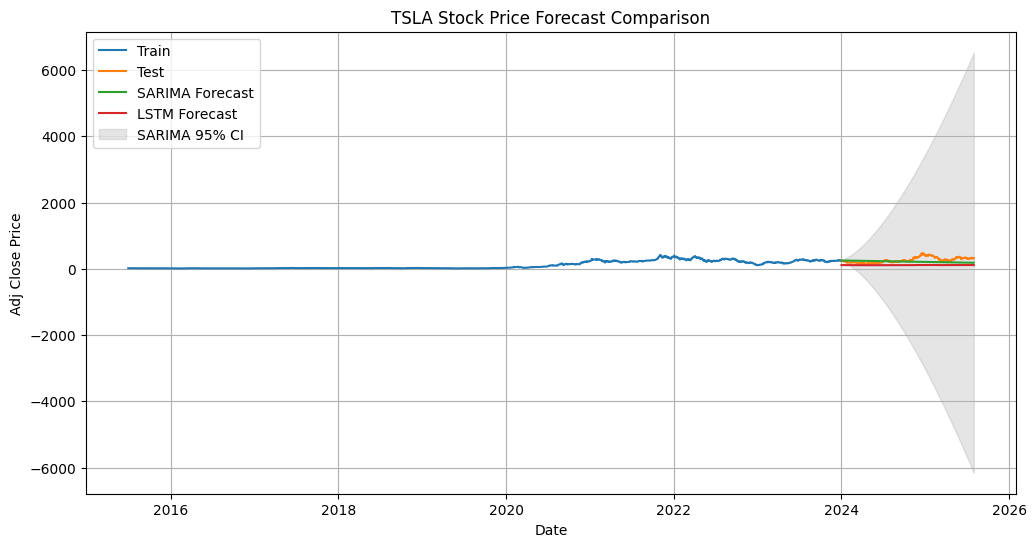

In [31]:
# Step 5: Plot Forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, sarima_pred, label='SARIMA Forecast')
plt.plot(test.index, lstm_pred, label='LSTM Forecast')
plt.fill_between(test.index, sarima_conf['lower TSLA_Close'] , sarima_conf['upper TSLA_Close'] , color='gray', alpha=0.2, label='SARIMA 95% CI')
plt.title('TSLA Stock Price Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.grid()
plt.show()

### Discussion

SARIMA Metrics: MAE=82.78, RMSE=103.37, MAPE=29.18% 

LSTM Metrics: MAE=10.17, RMSE=14.49, MAPE=3.69%

The metrics provided are performance evaluation results for the two forecasting models (SARIMA and LSTM) shown in the plot. Let’s break them down:

1. Mean Absolute Error (MAE)

Measures the average absolute difference between the predicted and actual values.

SARIMA: 82.78 → On average, SARIMA’s predictions are about $82.78 away from the actual stock price.

LSTM: 10.17 → On average, LSTM’s predictions are about $10.17 away.

👉 Lower is better → LSTM performs much better.

2. Root Mean Squared Error (RMSE)

Similar to MAE but penalizes larger errors more (since errors are squared).

SARIMA: 103.37

LSTM: 14.49

👉 Again, lower is better → LSTM clearly outperforms SARIMA.

3. Mean Absolute Percentage Error (MAPE)

Expresses error as a percentage of the actual values → useful for interpretability.

SARIMA: 29.18% → Predictions are off by ~29% on average.

LSTM: 3.69% → Predictions are off by ~3.7% on average.

👉 LSTM provides far more accurate percentage-based predictions.

The LSTM model is significantly more accurate than SARIMA for forecasting TSLA stock price, as seen by the much lower MAE, RMSE, and MAPE values.

SARIMA has much higher forecast uncertainty (shown in the wide gray cone in the plot), while LSTM follows the test data more closely.